### Mounting your google drive on Colab Noetebook

In [ ]:
from google.colab import drive
## esto te va a pedir autorización. 
# Entra al link. Dale los permisos. Copiate el passw y pegalo acá donde te lo pide
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 

In [ ]:
#%cd ../

In [111]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import manifold
from time import time
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# normed expression data
expr_data = pd.read_csv('./data/AMLdataset/data/GSE13425_Norm_Whole.tab',sep = '\t')
expr_data.rename(columns = {'Unnamed: 0':'gene'},inplace =True)
expr_data.set_index('gene',inplace =True)

#phenotype data
pheno_data = pd.read_csv('./data/AMLdataset/data/phenoData_GSE13425.tab',sep ='\t')

#group data
group_descr = pd.read_csv('./data/AMLdataset/data/GSE13425_group_descriptions.tab',sep = '\t')


In [25]:
display(expr_data.shape)
expr_data.head()

(22283, 190)

,GSM338666,GSM338667,GSM338668,GSM338669,GSM338670,GSM338671,GSM338672,GSM338673,GSM338674,GSM338675,...,GSM338846,GSM338847,GSM338848,GSM338849,GSM338850,GSM338851,GSM338852,GSM338853,GSM338854,GSM338855
gene,,,,,,,,,,,,,,,,,,,,,
DDR1|1007_s_at,4.38,4.38,4.23,3.98,5.12,3.90,4.18,4.23,4.20,4.21,...,4.47,4.88,5.73,5.55,4.15,6.16,4.23,5.18,4.68,4.55
RFC2|1053_at,3.44,3.33,3.73,3.58,3.40,3.07,3.02,3.37,2.97,3.22,...,2.90,3.40,3.04,2.88,2.88,2.89,3.34,3.02,3.07,2.99
HSPA6|117_at,2.51,2.62,2.37,2.43,2.49,2.57,2.69,2.74,2.40,2.59,...,2.61,2.31,2.48,2.68,4.09,2.65,2.83,2.66,2.54,2.64
PAX8|121_at,6.24,6.21,6.10,6.09,6.53,6.18,6.58,6.12,6.02,6.14,...,6.21,6.01,6.20,6.34,6.39,6.25,6.05,6.30,6.38,6.25
GUCA1A|1255_g_at,2.29,2.23,2.17,2.26,2.27,2.18,2.15,2.11,2.21,2.40,...,2.36,2.06,2.14,2.24,2.27,2.27,2.25,2.14,2.23,2.16


In [6]:
pheno_data.head()

,Sample.GEO.ID,Sample.title,Sample.source.name.ch1,Sample.characteristics.ch1,Sample.description,sample.labels,sample.colors
0,GSM338666,T-ALL,bone marrow or peripheral blood sample from ch...,T-ALL,Sample collected at diagnosis.,T,darkgreen
1,GSM338667,T-ALL,bone marrow or peripheral blood sample from ch...,T-ALL,Sample collected at diagnosis.,T,darkgreen
2,GSM338668,T-ALL,bone marrow or peripheral blood sample from ch...,T-ALL,Sample collected at diagnosis.,T,darkgreen
3,GSM338669,T-ALL,bone marrow or peripheral blood sample from ch...,T-ALL,Sample collected at diagnosis.,T,darkgreen
4,GSM338670,T-ALL,bone marrow or peripheral blood sample from ch...,T-ALL,Sample collected at diagnosis.,T,darkgreen


In [13]:
group_descr

,Unnamed: 0,group.labels,group.colors
0,T-ALL,T,darkgreen
1,TEL-AML1,Bt,red
2,TEL-AML1 + hyperdiploidy,Bth,blue
3,hyperdiploid,Bh,brown
4,E2A-rearranged (E),BE,green
5,E2A-rearranged (EP),BEp,orange
6,E2A-rearranged (E-sub),BEs,darkgray
7,BCR-ABL,Bc,cyan
8,BCR-ABL + hyperdiploidy,Bch,black
9,MLL,BM,violet


## Veamos cuántas categorías tenemos

In [12]:
pheno_data['Sample.title'].value_counts()

hyperdiploid                44
pre-B ALL                   44
TEL-AML1                    43
T-ALL                       36
E2A-rearranged (EP)          8
MLL                          4
BCR-ABL                      4
E2A-rearranged (E-sub)       4
E2A-rearranged (E)           1
TEL-AML1 + hyperdiploidy     1
BCR-ABL + hyperdiploidy      1
Name: Sample.title, dtype: int64

## Make data for classification

In [26]:
data = expr_data.transpose()
data.shape

(190, 22283)

## contamos con un dataset ya preprocesado (no tiene ni un solo NAn):

In [31]:
data.isna().any().any()

False

### Todas las muestras tienen medias y desvíos standard parecidos. 
### Hubo alguna normalización por muestra para asegurar que los 190 ensayos sean comparables

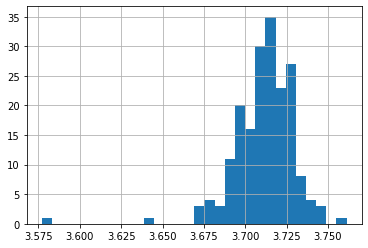

In [52]:
expr_data.apply(np.mean).hist(bins=30)

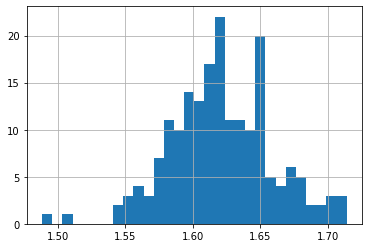

In [51]:
expr_data.apply(np.std).hist(bins=30)

### Si lo analizamos por gene, el escenario cambia. 

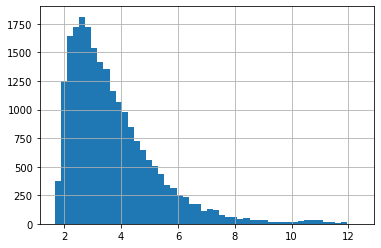

In [53]:
gene_mean = expr_data.apply(np.mean,axis =1)
gene_mean.hist(bins = 50)

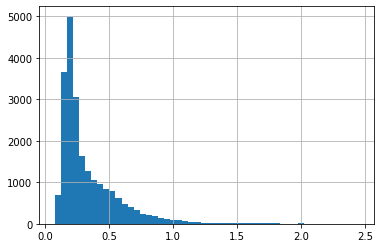

In [48]:
gene_std = expr_data.apply(np.std,axis =1)
gene_std.hist(bins = 50)

In [54]:
gene_std.sort_values(ascending=False).head()

gene
CD9|201005_at         2.451680
IL23A|211796_s_at     2.428608
CD3D|213539_at        2.380407
S100A8|202917_s_at    2.340341
KLF4|221841_s_at      2.284268
dtype: float64

In [55]:
gene_mean.sort_values(ascending=False).head()

gene
NA|AFFX-hum_alu_at        12.376737
RPL41|201492_s_at         12.182895
TPT1|212869_x_at          12.147895
NA|207783_x_at            12.044842
NA|AFFX-r2-P1-cre-3_at    11.940632
dtype: float64

## add target column

In [141]:
merged = pd.merge(data,pheno_data[['Sample.GEO.ID','sample.labels']],left_index=True,right_on=['Sample.GEO.ID']).drop(['Sample.GEO.ID'],axis =1)

# PCA

0.5252912044525146


/home/ariel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


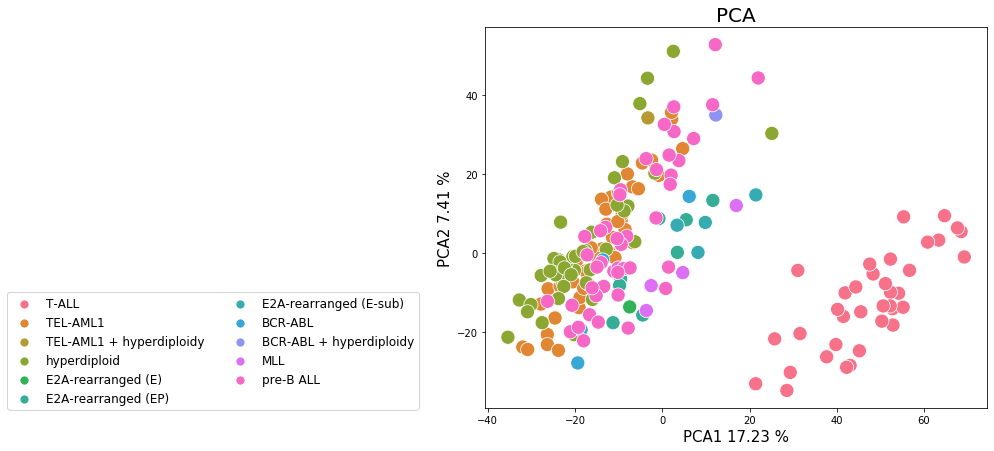

In [272]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
t0 = time()
Ypca = pca.fit_transform(data)
pca1 = 100*pca.explained_variance_ratio_[0]
pca2 = 100*pca.explained_variance_ratio_[1]

t1 = time()
print (t1-t0)
fig = plt.figure(figsize=(9, 7))
s = pd.Series([1]*Ypca.shape[0])
g =sns.scatterplot(x=Ypca[:, 0], y=Ypca[:, 1],hue = pheno_data['Sample.title'],size= s,sizes = (200,200),
                   legend= 'full')
handles = g.get_legend_handles_labels()[0][1:-1]
labels = g.get_legend_handles_labels()[1][1:-1]
g.legend(loc='bottom right', bbox_to_anchor=(-0.12, 0.32), ncol=2,handles = handles, labels= labels,
         fontsize=12,markerscale= 1.2)

plt.title("PCA",size = 20)
plt.xlabel('PCA1 %.2f %%'%pca1,size = 15)
plt.ylabel('PCA2 %.2f %%'%pca2,size = 15)

plt.savefig('PCA.AML.png')

# T-SNE

No handles with labels found to put in legend.


2.764904260635376
2.76567006111145


/home/ariel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


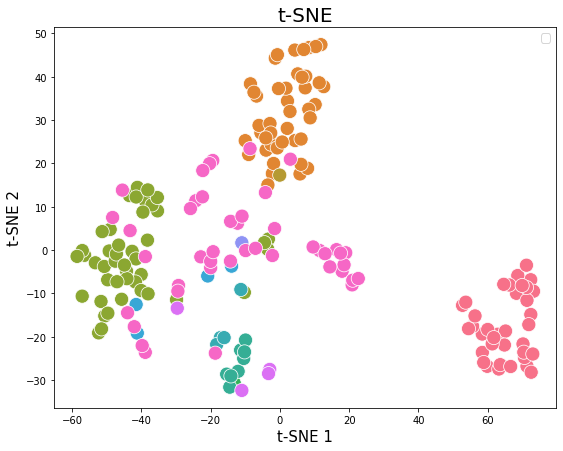

In [259]:
n_components = 2
tsne = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0,perplexity = 5)
t0 = time()
Y = tsne.fit_transform(data)
t1 = time()
print(t1-t0)



t1 = time()
print (t1-t0)
fig = plt.figure(figsize=(9, 7))
s = pd.Series([1]*Ypca.shape[0])

g =sns.scatterplot(x=Y[:, 0], y=Y[:, 1],hue = pheno_data['Sample.title'],size= s,sizes = (200,200),
                   legend= False)
handles = g.get_legend_handles_labels()[0][1:-1]
labels = g.get_legend_handles_labels()[1][1:-1]
g.legend(loc='top right', bbox_to_anchor=(1, 1), ncol=2,handles = handles, labels= labels,
         fontsize=12,markerscale= 1.2)

plt.title("t-SNE",size = 20)
plt.xlabel('t-SNE 1',size = 15)
plt.ylabel('t-SNE 2',size = 15)

plt.savefig('TSNE.AML.png')
# Create figure





In [144]:
X = merged.drop('sample.labels',axis = 1).copy(); y = merged['sample.labels'].copy()
y[y!='Bo'] = 'others'
y.value_counts()

others    146
Bo         44
Name: sample.labels, dtype: int64